<a href="https://colab.research.google.com/github/feodosiya/DL_HW/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

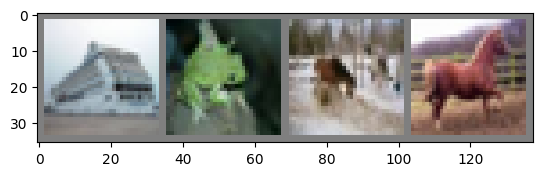

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
torch.autograd.set_detect_anomaly(True) # дебаг

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),  # inplace=False пришлось указать, чтобы избавиться от ошибки при запуске обучения
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False)
        )

        self.conv1x1 = nn.Conv2d(3, 32, kernel_size=1)

        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        residual = self.conv1x1(x)
        out = self.conv_block(x)
        out = out + residual

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        out = self.fc(out)

        return out


In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad(): # нет необходимости вычислять градиенты
        for data, target in loader:
            data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)

            _, preds = torch.max(output, 1)
            correct = (preds == target).sum().item() # Для accuracy
            acc = correct / target.size(0)

            loss_log.append(loss.item())
            acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()

        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(output, 1)
        correct = (preds == target).sum().item()
        acc = correct / target.size(0)

        loss_log.append(loss.item())
        acc_log.append(acc)

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4770157686971006, train acc: 0.4763156176547402
 val loss: 1.2746576522259, val acc: 0.5474290780141843

Epoch 1
 train loss: 1.2305297651064244, train acc: 0.5700941825541918
 val loss: 1.1918043311606061, val acc: 0.5852171985815604

Epoch 2
 train loss: 1.136892371247412, train acc: 0.6025724732306086
 val loss: 1.1656454261313094, val acc: 0.6112588652482269

Epoch 3
 train loss: 1.0862668454102231, train acc: 0.6215803734656569
 val loss: 1.0914004062084441, val acc: 0.6223404255319149

Epoch 4
 train loss: 1.0493816737718948, train acc: 0.6384499869417604
 val loss: 1.0197099284922824, val acc: 0.6453900709219859

Epoch 5
 train loss: 1.0314405260835748, train acc: 0.6413513645860538
 val loss: 1.000113617105687, val acc: 0.6506648936170213

Epoch 6
 train loss: 1.0128386537161345, train acc: 0.6508512340036563
 val loss: 1.0695502065597697, val acc: 0.6350842198581561

Epoch 7
 train loss: 0.9944360329202586, train acc: 0.655666459911204
 val loss: 1.02088

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

 accuracy: 0.6710788216560509


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
import matplotlib.pyplot as plt

train_loss_lst, train_acc_lst = [], []
val_loss_lst, val_acc_lst = [], []

net = BasicBlockNet().to(device) # переинициализируем модель
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

for epoch in range(20):

    train_loss, train_acc = train_epoch(net, optimizer, train_loader)
    train_loss_lst.extend(train_loss)
    train_acc_lst.extend(train_acc)

    val_loss, val_acc = test(net, val_loader)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

    print(f"epoch {epoch}: train loss {np.mean(train_loss)}, train acc {np.mean(train_acc)}, val loss: {val_loss}, val acc: {val_acc}")


epoch 0: train loss 1.4986041191509045, train acc 0.46826847740924515, val loss: 1.2582955073803028, val acc: 0.5612588652482269
epoch 1: train loss 1.2416539557237294, train acc 0.5681966570906242, val loss: 1.215087139352839, val acc: 0.5745345744680851
epoch 2: train loss 1.1429455125571606, train acc 0.602217452337425, val loss: 1.2607912142226037, val acc: 0.5701684397163119
epoch 3: train loss 1.0938666953247251, train acc 0.6205479563854792, val loss: 1.1214714108629429, val acc: 0.6151152482269503
epoch 4: train loss 1.0718091290437326, train acc 0.6276565356489945, val loss: 1.0529197895780522, val acc: 0.6348847517730497
epoch 5: train loss 1.0372870910974046, train acc 0.640775985897101, val loss: 1.003852932503883, val acc: 0.6551418439716311
epoch 6: train loss 1.014800746218596, train acc 0.6519203773831288, val loss: 1.0815348391837263, val acc: 0.6263962765957447
epoch 7: train loss 0.9961181726490558, train acc 0.6546013972316531, val loss: 1.0710922634347957, val acc:

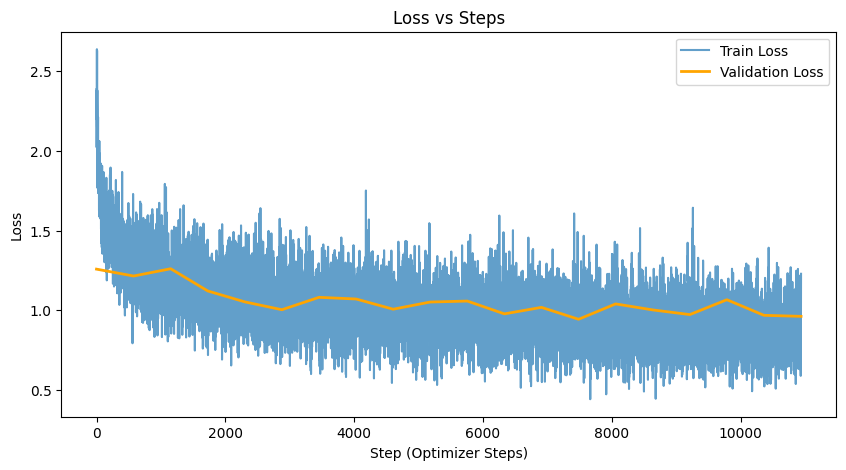

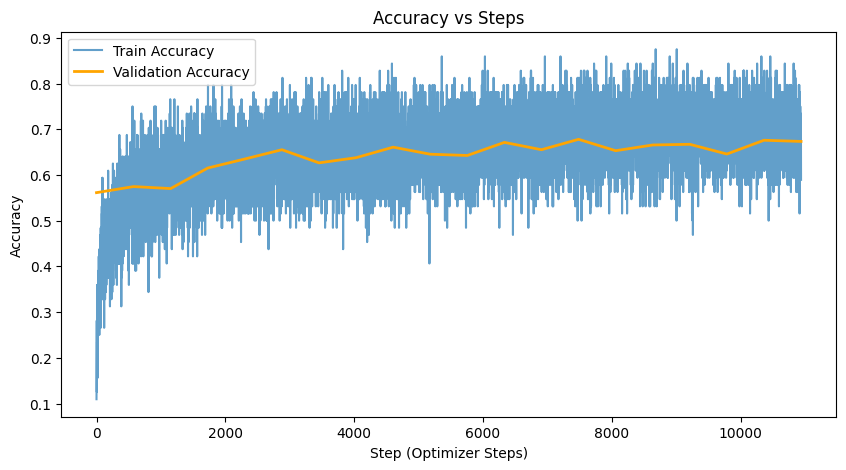

In [ ]:
steps = np.arange(len(train_loss_lst))
val_steps = np.linspace(0, len(train_loss_lst) - 1, num=len(val_loss_lst))
# с графиками помог chatgpt, промт: фрамгент кода со списками и запрос на отрисовку графиков раздельно для loss и accuracy

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss_lst, label='Train Loss', alpha=0.7)
plt.plot(val_steps, val_loss_lst, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Step (Optimizer Steps)')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Steps')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(steps, train_acc_lst, label='Train Accuracy', alpha=0.7)
plt.plot(val_steps, val_acc_lst, label='Validation Accuracy', color='orange', linewidth=2)
plt.xlabel('Step (Optimizer Steps)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Steps')
plt.show()


## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4966896242807726, train acc: 0.4683664142073648
 val loss: 1.2839280166524523, val acc: 0.5568040780141843

Epoch 1
 train loss: 1.225551455831615, train acc: 0.572016192217289
 val loss: 1.1600563320707769, val acc: 0.5931294326241136

Epoch 2
 train loss: 1.1408474686158858, train acc: 0.6076284604335336
 val loss: 1.1351256035743875, val acc: 0.6138519503546098

Epoch 3
 train loss: 1.0951275306820216, train acc: 0.6227637764429355
 val loss: 1.0997103216800284, val acc: 0.6165336879432625

Epoch 4
 train loss: 1.0452691493130253, train acc: 0.6367197701749804
 val loss: 1.0595802946293609, val acc: 0.6382092198581562

Epoch 5
 train loss: 1.0284209273197098, train acc: 0.6461869939932098
 val loss: 1.101423492330186, val acc: 0.6165336879432625

Epoch 6
 train loss: 1.0109571069206573, train acc: 0.6514878231914338
 val loss: 1.1173275242460534, val acc: 0.6162012411347518

Epoch 7
 train loss: 0.9835074006748373, train acc: 0.6603470227213372
 val loss: 1.05

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

 accuracy: 0.7107882165605095


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.812564864672952, train acc: 0.3686381888221468
 val loss: 1.5878922523336207, val acc: 0.44173315602836877

Epoch 1
 train loss: 1.5108084197018221, train acc: 0.4709903042569862
 val loss: 1.439560528004423, val acc: 0.49366134751773044

Epoch 2
 train loss: 1.3968267663087444, train acc: 0.5103772199007574
 val loss: 1.3642406773059925, val acc: 0.5237145390070922

Epoch 3
 train loss: 1.3253626913867442, train acc: 0.5362610995037869
 val loss: 1.2921097380049684, val acc: 0.5476507092198583

Epoch 4
 train loss: 1.2631294726235776, train acc: 0.5599250783494386
 val loss: 1.252762434837666, val acc: 0.5579122340425532

Epoch 5
 train loss: 1.214083579711112, train acc: 0.5802551253591015
 val loss: 1.2065533904319115, val acc: 0.5782136524822694

Epoch 6
 train loss: 1.167710295216039, train acc: 0.5938846630974145
 val loss: 1.1694486970597124, val acc: 0.5903590425531915

Epoch 7
 train loss: 1.1284720704803954, train acc: 0.6111705079655263
 val loss: 1.12

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# Из доки: https://pytorch.org/docs/stable/optim.html
# lr_scheduler.StepLR - Decays the learning rate of each parameter group by gamma every step_size epochs.

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.5105375596330632, train acc: 0.4604580177592061
 val loss: 1.2845281958580017, val acc: 0.5501773049645391

Epoch 1
 train loss: 1.26896281052769, train acc: 0.5534122812744843
 val loss: 1.2037535532991936, val acc: 0.5712987588652482

Epoch 2
 train loss: 1.1670255526982016, train acc: 0.5940723752938104
 val loss: 1.1956665995273184, val acc: 0.5841533687943263

Epoch 3
 train loss: 1.1147042877931264, train acc: 0.6150022851919561
 val loss: 1.1479290439727459, val acc: 0.6095079787234042

Epoch 4
 train loss: 1.0669275092904267, train acc: 0.6302028924001044
 val loss: 1.092727766392079, val acc: 0.6181294326241136

Epoch 5
 train loss: 1.0423444133571995, train acc: 0.6402495756072082
 val loss: 1.0901029992610851, val acc: 0.6327570921985817

Epoch 6
 train loss: 1.0136812650743308, train acc: 0.6508879603029512
 val loss: 1.0054146363380108, val acc: 0.6518395390070922

Epoch 7
 train loss: 0.9941102112668959, train acc: 0.6560786106032906
 val loss: 1.07

In [ ]:
# lr_scheduler.ExponentialLR - Decays the learning rate of each parameter group by gamma every epoch.

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')


Epoch 0
 train loss: 1.4710546072701867, train acc: 0.48000457038391225
 val loss: 1.3437857338722716, val acc: 0.5322695035460993

Epoch 1
 train loss: 1.2208698762400276, train acc: 0.5708368699399321
 val loss: 1.1731222238946468, val acc: 0.5902039007092199

Epoch 2
 train loss: 1.1208471113192753, train acc: 0.6117499673544006
 val loss: 1.095854227086331, val acc: 0.6087544326241136

Epoch 3
 train loss: 1.0708569060513917, train acc: 0.6262446134761034
 val loss: 1.098961298516456, val acc: 0.6194813829787233

Epoch 4
 train loss: 1.024929726581469, train acc: 0.6431917602507182
 val loss: 1.0276264408801465, val acc: 0.6421764184397162

Epoch 5
 train loss: 0.9896003236718326, train acc: 0.6568049751893446
 val loss: 1.033443047898881, val acc: 0.6484707446808511

Epoch 6
 train loss: 0.9617253799107218, train acc: 0.6669618372943327
 val loss: 0.9949394170274126, val acc: 0.6590425531914894

Epoch 7
 train loss: 0.9367619455950351, train acc: 0.6735766518673283
 val loss: 0.99

In [ ]:
# lr_scheduler.ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
# возьму код из функции, чтобы передать метрику в шаг - scheduler.step(val_loss)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []


net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for epoch in range(20):
  train_loss, train_acc = train_epoch(net, optimizer, train_loader)
  val_loss, val_acc = test(net, val_loader)

  train_loss_log.extend(train_loss)
  train_acc_log.extend(train_acc)

  val_loss_log.append(val_loss)
  val_acc_log.append(val_acc)

  print(f"Epoch {epoch}")
  print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
  print(f" val loss: {val_loss}, val acc: {val_acc}\n")

  scheduler.step(val_loss)


test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')


Epoch 0
 train loss: 1.5078165349184487, train acc: 0.46617099764951686
 val loss: 1.2796464635970746, val acc: 0.5455230496453901

Epoch 1
 train loss: 1.2269039944059452, train acc: 0.5698534212588143
 val loss: 1.164423036828954, val acc: 0.5883421985815603

Epoch 2
 train loss: 1.1480706712227635, train acc: 0.5998792112823191
 val loss: 1.058296946769065, val acc: 0.633200354609929

Epoch 3
 train loss: 1.0926222969016819, train acc: 0.6215926155654218
 val loss: 1.0694870000189922, val acc: 0.625177304964539

Epoch 4
 train loss: 1.0510322423260217, train acc: 0.6385071167406634
 val loss: 1.0232451636740503, val acc: 0.6462101063829787

Epoch 5
 train loss: 1.0257393390866476, train acc: 0.6454769522068425
 val loss: 1.0697005058856721, val acc: 0.6351507092198583

Epoch 6
 train loss: 1.014825052600456, train acc: 0.6503085009140768
 val loss: 1.034954365263594, val acc: 0.6383200354609928

Epoch 7
 train loss: 0.9888220173349328, train acc: 0.658959584747976
 val loss: 1.04945

Your answers here:
- **StepLR** снижает lr на каждом шаге после некоторого числа эпох (step_size) на фиксированный коэффициент.
- **ExponentialLR** снижает lr экспоненциально в ходе обучения. Степень гаммы зависит от шага.
- **ReduceLROnPlateau** уменьшает lr, когда метрика перестает улучшаться. Можно отрегулировать количество эпох без улучшений, после которых шаг уменьшится. Также можно выбрать потерю или точность.

В моем случае лучший результат показал MultiStepLR (самый первый тест), после него StepLR.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

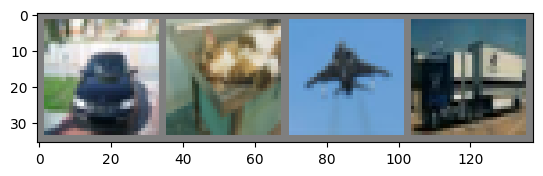

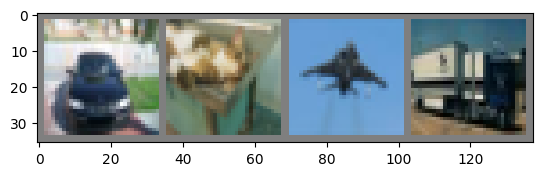

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4892525618429375, train acc: 0.47044349046748496
 val loss: 1.279833294990215, val acc: 0.5495345744680851

Epoch 1
 train loss: 1.2364336051714269, train acc: 0.5661155001305823
 val loss: 1.1527408112870885, val acc: 0.5983820921985816

Epoch 2
 train loss: 1.1516102606897163, train acc: 0.599226299294855
 val loss: 1.0748001205160262, val acc: 0.6224290780141843

Epoch 3
 train loss: 1.0898460606334415, train acc: 0.6230208605379995
 val loss: 1.0412818865573152, val acc: 0.6420656028368795

Epoch 4
 train loss: 1.0600101967398383, train acc: 0.6324064703577957
 val loss: 1.155141383029045, val acc: 0.609264184397163

Epoch 5
 train loss: 1.0320152446382442, train acc: 0.6429428375554974
 val loss: 1.0632647420497652, val acc: 0.628656914893617

Epoch 6
 train loss: 1.0202181463485662, train acc: 0.6462726886915644
 val loss: 1.0151620238385302, val acc: 0.6475620567375886

Epoch 7
 train loss: 1.0073531937991462, train acc: 0.6524345455732568
 val loss: 1.016

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

 accuracy: 0.7191480891719745


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# Из доки: https://pytorch.org/vision/0.9/transforms.html
# RandomRotation - Rotate the image by angle

transform_rotation = transforms.Compose(
    [
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_rotation
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.6058810343472134, train acc: 0.4265025137111517
 val loss: 1.3923022914440073, val acc: 0.4990691489361702

Epoch 1
 train loss: 1.4086777442552054, train acc: 0.4969966048576652
 val loss: 1.3616827528527442, val acc: 0.5173093971631205

Epoch 2
 train loss: 1.3427608430494555, train acc: 0.525655360407417
 val loss: 1.315823131165606, val acc: 0.5338209219858157

Epoch 3
 train loss: 1.2994851388268758, train acc: 0.5400765539305301
 val loss: 1.326707554370799, val acc: 0.5382092198581561

Epoch 4
 train loss: 1.2816016829863763, train acc: 0.5484909571689736
 val loss: 1.2133203270587516, val acc: 0.5690381205673758

Epoch 5
 train loss: 1.2339718086845914, train acc: 0.5642587816662313
 val loss: 1.224657841185306, val acc: 0.5728501773049646

Epoch 6
 train loss: 1.2309139442836128, train acc: 0.5699921650561505
 val loss: 1.269396115617549, val acc: 0.5498448581560285

Epoch 7
 train loss: 1.22441818966944, train acc: 0.5706328349438495
 val loss: 1.206603

In [ ]:
# RandomResizedCrop - Crop the given image to random size and aspect ratio.

transform_resized_crop = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_resized_crop
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.554202446771932, train acc: 0.44782417080177594
 val loss: 1.3344574243464369, val acc: 0.5314494680851064

Epoch 1
 train loss: 1.3186091003731792, train acc: 0.535326619221729
 val loss: 1.2879074111897895, val acc: 0.5547429078014183

Epoch 2
 train loss: 1.2595710890602585, train acc: 0.5621857861060329
 val loss: 1.2311779473690276, val acc: 0.5722517730496455

Epoch 3
 train loss: 1.2094063954989696, train acc: 0.5809406829459388
 val loss: 1.1635639599029055, val acc: 0.5936835106382978

Epoch 4
 train loss: 1.1828942709692654, train acc: 0.589861092974667
 val loss: 1.158782859305118, val acc: 0.5972739361702127

Epoch 5
 train loss: 1.1426048802937188, train acc: 0.60302135022199
 val loss: 1.344417127396198, val acc: 0.5489804964539008

Epoch 6
 train loss: 1.131032704871141, train acc: 0.6108603747714808
 val loss: 1.1296968680747013, val acc: 0.6106161347517731

Epoch 7
 train loss: 1.1205134757911919, train acc: 0.6123947179420214
 val loss: 1.107355

In [ ]:
# RandomAffine - Random affine transformation of the image keeping center invariant.

transform_affine = transforms.Compose(
    [
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_affine
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.7428629206565005, train acc: 0.3749918386001567
 val loss: 1.5541558027267457, val acc: 0.4377437943262411

Epoch 1
 train loss: 1.5589391729731445, train acc: 0.4426212784016714
 val loss: 1.6171472990766484, val acc: 0.43785460992907804

Epoch 2
 train loss: 1.4996455247485005, train acc: 0.4667667798380778
 val loss: 1.4647408629985565, val acc: 0.4822916666666666

Epoch 3
 train loss: 1.4617694875657885, train acc: 0.47975564768869156
 val loss: 1.377224835436395, val acc: 0.5089760638297872

Epoch 4
 train loss: 1.4259939043351892, train acc: 0.4921446526508227
 val loss: 1.409571312843485, val acc: 0.5079787234042553

Epoch 5
 train loss: 1.3861948406456592, train acc: 0.5077329263515278
 val loss: 1.3980539869754873, val acc: 0.5058510638297873

Epoch 6
 train loss: 1.3839940349188322, train acc: 0.5126012013580569
 val loss: 1.3969508985255628, val acc: 0.5082446808510638

Epoch 7
 train loss: 1.3741256439925549, train acc: 0.5176490271611387
 val loss: 1

In [ ]:
# ColorJitter - Randomly change the brightness, contrast, saturation and hue of an image.

transform_jitter = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_jitter
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.5717562539485952, train acc: 0.4394301710629407
 val loss: 1.3541323063221384, val acc: 0.5222517730496454

Epoch 1
 train loss: 1.3089711169220193, train acc: 0.5401826521284931
 val loss: 1.2065887075789432, val acc: 0.5812721631205673

Epoch 2
 train loss: 1.2182483113008182, train acc: 0.5749379733611909
 val loss: 1.2521732350613208, val acc: 0.5671320921985816

Epoch 3
 train loss: 1.1574389119470796, train acc: 0.6000138743797336
 val loss: 1.18309170692525, val acc: 0.5976285460992907

Epoch 4
 train loss: 1.1218984061664812, train acc: 0.6157204883781665
 val loss: 1.1841966611273744, val acc: 0.5953900709219859

Epoch 5
 train loss: 1.0894904923395439, train acc: 0.623306509532515
 val loss: 1.1825423304070817, val acc: 0.5917553191489362

Epoch 6
 train loss: 1.0694293270817186, train acc: 0.6305660746931314
 val loss: 1.117920807067384, val acc: 0.6183510638297872

Epoch 7
 train loss: 1.0557158885751825, train acc: 0.6370054191694959
 val loss: 1.081

In [ ]:
# все вместе даже не обучалось, выбрала 3 с лучшим качеством

transform_combined = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_combined
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss, test_acc = test(net, test_loader)

print(f' accuracy: {test_acc}')

Epoch 0
 train loss: 1.6568665528428184, train acc: 0.41277095847479756
 val loss: 1.508484366092276, val acc: 0.46252216312056743

Epoch 1
 train loss: 1.434350801560299, train acc: 0.4989308566205275
 val loss: 1.4278576992927714, val acc: 0.5019503546099291

Epoch 2
 train loss: 1.3528959818688346, train acc: 0.5279936014625228
 val loss: 1.3806890931535274, val acc: 0.5164893617021277

Epoch 3
 train loss: 1.2934840358589423, train acc: 0.5506251632279968
 val loss: 1.3116834183956714, val acc: 0.5482712765957447

Epoch 4
 train loss: 1.2724016502744755, train acc: 0.5580969247845391
 val loss: 1.2332013868271037, val acc: 0.5750443262411349

Epoch 5
 train loss: 1.2421627174347802, train acc: 0.5685884042831025
 val loss: 1.3556270792129193, val acc: 0.5370124113475178

Epoch 6
 train loss: 1.24314754089882, train acc: 0.5697105967615566
 val loss: 1.2741210376962702, val acc: 0.5680407801418439

Epoch 7
 train loss: 1.217369401803618, train acc: 0.5779821755027422
 val loss: 1.25

Your answers here:
- RandomRotation - поворачивает картинку на некоторый угол (в нашем случае в диапазоне от -30 до +30)
- RandomResizedCrop - обрезает картинку случайным образом и подгоняет под заданные пропорции.
- RandomAffine - применяет случайную аффинную трансформацию (т.е. масштабирование, поворот, сдвиг и т.д.)
- ColorJitter - изменяет яркость, контрастность, насыщенность и оттенок.

Каждая по отдельности немного ухудшила качество на тесте. Вместе - еще сильнее понизили.

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

```https://api.wandb.ai/links/feomak16-hse/0t2hvfwa```

In [ ]:
! pip install wandb -q

In [ ]:
import wandb

wandb.init(project="cifar10_training", entity="feomak16-hse")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: feomak16 (feomak16-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

for epoch in range(20):
    train_loss, train_acc = train_epoch(net, optimizer, train_loader)
    train_loss_log.extend(train_loss)
    train_acc_log.extend(train_acc)

    val_loss, val_acc = test(net, val_loader)
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)

    wandb.log({
        "train_loss": np.mean(train_loss), # усредняю, чтобы было посимпатичнее. помилуйте, на всякий случай
        "train_accuracy": np.mean(train_acc),
        "val_loss": val_loss,
        "val_accuracy": val_acc,
    })

    scheduler.step()

    print(f"epoch {epoch}: train loss {np.mean(train_loss)}, train acc {np.mean(train_acc)}, val loss: {val_loss}, val acc: {val_acc}")


epoch 0: train loss 1.702210258522243, train acc 0.39284490075737794, val loss: 1.5275660748177387, val acc: 0.4586214539007092
epoch 1: train loss 1.456136257164657, train acc 0.4865214481587881, val loss: 1.353824237559704, val acc: 0.5320478723404255
epoch 2: train loss 1.3713868646124816, train acc 0.5229743405588927, val loss: 1.3355445653834241, val acc: 0.5287898936170212
epoch 3: train loss 1.3252989234610493, train acc 0.5399051645338209, val loss: 1.331569151168174, val acc: 0.5372118794326242
epoch 4: train loss 1.2849787525982481, train acc 0.5549996735440063, val loss: 1.2349751754009977, val acc: 0.5674202127659574
epoch 5: train loss 1.2502477552598747, train acc 0.5671234330112301, val loss: 1.1940068059779227, val acc: 0.5840868794326242
epoch 6: train loss 1.2372224100982903, train acc 0.5733628231914338, val loss: 1.2343231650108988, val acc: 0.5823803191489362
epoch 7: train loss 1.2211042724318217, train acc 0.5809733285453121, val loss: 1.18268941158944, val acc: 

In [ ]:
test_loss, test_acc = test(net, test_loader)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

wandb.finish()

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▅▅▆▆▆▆▇█████████
train_loss,█▆▅▄▄▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▅▅▅▆▆▇▇█▇▇█████
val_loss,█▆▆▆▄▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁
test_accuracy,0.68252
test_loss,0.93059
train_accuracy,0.67292
train_loss,0.95405
val_accuracy,0.66897


Test Loss: 0.9305929556773727, Test Accuracy: 0.6825238853503185
